In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup Data

In [54]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout, Conv1D, Conv1DTranspose
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [55]:
data = pd.read_csv('/content/drive/MyDrive/Deep Learning/Project/Task-2/ad_train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Deep Learning/Project/Task-2/ad_test.csv')

data = data[1:167885]  ## records for patient 1502 and 1503 otherwise colab crashes
data = data.drop(['tsDate', 'patient'], axis = 1)
data_test = data_test.drop(['tsDate', 'patient'], axis = 1)
n = len(data)

train_df = data[0:int(n*0.8)]
val_df = data[int(n*0.8):]
test_df = data_test

#Scaling

In [ ]:

from sklearn.preprocessing import MinMaxScaler

train = train_df
scalers={}

for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

val = val_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(val[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    val[i]=s_s

test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

# Window Splitting

In [57]:
n_past = 60
n_future = 60
n_features = 5

def split_series(series, n_past, n_future):
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [8]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_val, y_val = split_series(val.values, n_past, n_future)
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], n_features))

X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [15]:
X_train.shape[1]

60

#Modeling

## Model 1

In [72]:
encoder_inputs = Input(shape=(n_past, n_features))
encoder_l1 = LSTM(16, return_state=True, activation='tanh')
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
#
decoder_inputs = RepeatVector(n_future)(encoder_outputs1[0])
#
decoder_l1 = LSTM(16, return_sequences=True, activation='tanh')(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
#
model1 = Model(encoder_inputs,decoder_outputs1)
#
model1.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 60, 5)]      0           []                               
                                                                                                  
 lstm_43 (LSTM)                 [(None, 16),         1408        ['input_8[0][0]']                
                                 (None, 16),                                                      
                                 (None, 16)]                                                      
                                                                                                  
 repeat_vector_23 (RepeatVector  (None, 60, 16)      0           ['lstm_43[0][0]']                
 )                                                                                          

In [73]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
history = {}

model1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanAbsoluteError())
history["model1"] = model1.fit(X_train, y_train, epochs=5, validation_data=(X_val,y_val), batch_size=64, verbose=1, callbacks=[reduce_lr])

Epoch 1/5
2097/2097 [==============================] - 111s 51ms/step - loss: 0.0933 - val_loss: 0.0843 - lr: 0.0010
Epoch 2/5
2097/2097 [==============================] - 112s 53ms/step - loss: 0.0793 - val_loss: 0.0799 - lr: 9.0000e-04
Epoch 3/5
2097/2097 [==============================] - 109s 52ms/step - loss: 0.0782 - val_loss: 0.0790 - lr: 8.1000e-04
Epoch 4/5
2097/2097 [==============================] - 115s 55ms/step - loss: 0.0776 - val_loss: 0.0776 - lr: 7.2900e-04
Epoch 5/5
2097/2097 [==============================] - 97s 46ms/step - loss: 0.0772 - val_loss: 0.0776 - lr: 6.5610e-04


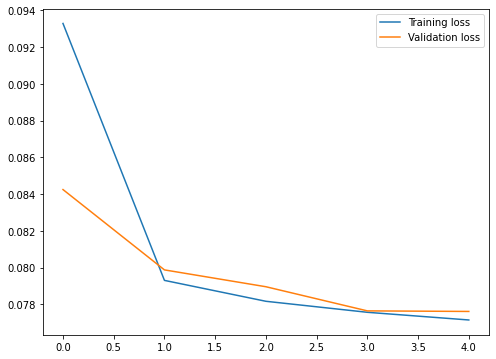

In [74]:
plt.plot(history['model1'].history['loss'], label='Training loss')
plt.plot(history['model1'].history['val_loss'], label='Validation loss')
plt.legend()

In [75]:
trainPredict = model1.predict(X_train)

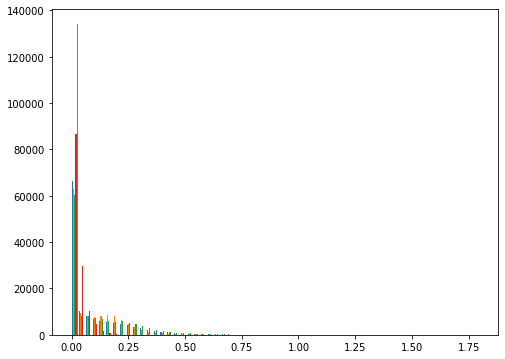

In [76]:
trainMAE = np.mean(np.abs(trainPredict - X_train), axis=1)
plt.hist(trainMAE, bins=60)
max_trainMAE = 0.5

In [77]:
testPredict = model1.predict(X_test)

(array([[ 32567.,  15429.,  19781.,  16926.,  15514.,  19758.,  12796.,
          14799.,  17410.,  19103.,  17426.,  20364.,  15268.,  18071.,
          15987.,  17011.,  15177.,   6943.,  15942.,  19752.,  13189.,
          14582.,  11501.,  16713.,  11116.,  10524.,  11606.,  12640.,
          10333.,  12773.,  11980.,  11888.,  10851.,  15222.,  12460.,
          13961.,  12640.,  10077.,  14086.,  12159.,  14016.,  15840.,
          11796.,   6243.,   6437.,   6710.,   6470.,   4757.,   5390.,
           3498.,   3095.,   5261.,   4878.,   3691.,   3331.,   3193.,
           5051.,   5407.,   4880.,   6399.],
        [722668.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0., 

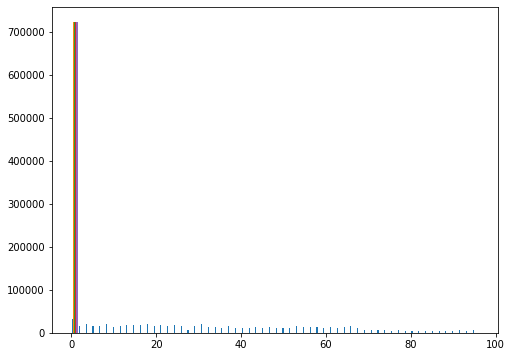

In [78]:
testMAE = np.mean(np.abs(testPredict - X_test), axis=1)
plt.hist(testMAE, bins=60)

## Model 2

In [79]:

model2 = Sequential()
model2.add(LSTM(16, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model2.add(LSTM(8, activation='tanh', return_sequences=False))
model2.add(RepeatVector(X_train.shape[1]))
model2.add(LSTM(8, activation='tanh', return_sequences=True))
model2.add(LSTM(16, activation='tanh', return_sequences=True))
model2.add(TimeDistributed(Dense(X_train.shape[2])))

model2.compile(optimizer='adam', loss='mse')
model2.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 60, 16)            1408      
                                                                 
 lstm_46 (LSTM)              (None, 8)                 800       
                                                                 
 repeat_vector_24 (RepeatVec  (None, 60, 8)            0         
 tor)                                                            
                                                                 
 lstm_47 (LSTM)              (None, 60, 8)             544       
                                                                 
 lstm_48 (LSTM)              (None, 60, 16)            1600      
                                                                 
 time_distributed_14 (TimeDi  (None, 60, 5)            85        
 stributed)                                          

In [80]:
history["model2"] = model2.fit(X_train, y_train, epochs=5, validation_data=(X_val,y_val), batch_size=512, verbose=1)

Epoch 1/5
263/263 [==============================] - 61s 208ms/step - loss: 0.0820 - val_loss: 0.0575
Epoch 2/5
263/263 [==============================] - 51s 193ms/step - loss: 0.0384 - val_loss: 0.0529
Epoch 3/5
263/263 [==============================] - 53s 201ms/step - loss: 0.0345 - val_loss: 0.0499
Epoch 4/5
263/263 [==============================] - 54s 204ms/step - loss: 0.0327 - val_loss: 0.0466
Epoch 5/5
263/263 [==============================] - 58s 221ms/step - loss: 0.0316 - val_loss: 0.0450


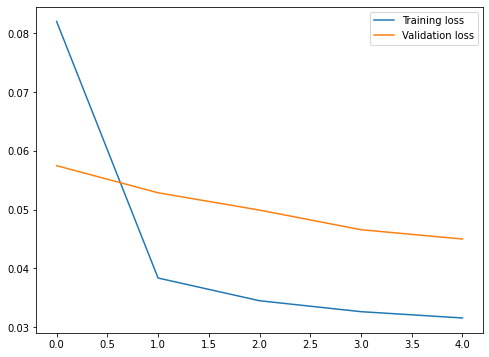

In [81]:
plt.plot(history['model2'].history['loss'], label='Training loss')
plt.plot(history['model2'].history['val_loss'], label='Validation loss')
plt.legend()

In [82]:
trainPredict2 = model2.predict(X_train)

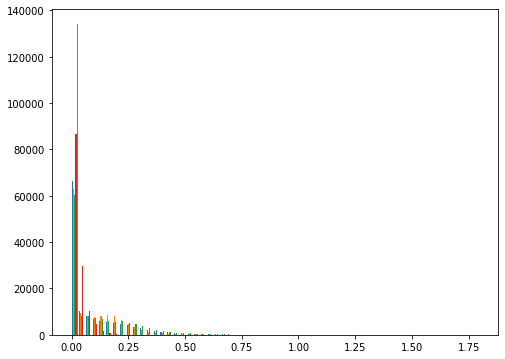

In [83]:
trainMAE2 = np.mean(np.abs(trainPredict - X_train), axis=1)
plt.hist(trainMAE, bins=60)
max_trainMAE2 = 0.5

In [84]:
testPredict2 = model2.predict(X_test)


(array([[ 32567.,  15429.,  19781.,  16926.,  15514.,  19758.,  12796.,
          14799.,  17410.,  19103.,  17426.,  20364.,  15268.,  18071.,
          15987.,  17011.,  15177.,   6943.,  15942.,  19752.,  13189.,
          14582.,  11501.,  16713.,  11116.,  10524.,  11606.,  12640.,
          10333.,  12773.,  11980.,  11888.,  10851.,  15222.,  12460.,
          13961.,  12640.,  10077.,  14086.,  12159.,  14016.,  15840.,
          11796.,   6243.,   6437.,   6710.,   6470.,   4757.,   5390.,
           3498.,   3095.,   5261.,   4878.,   3691.,   3331.,   3193.,
           5051.,   5407.,   4880.,   6399.],
        [722668.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0., 

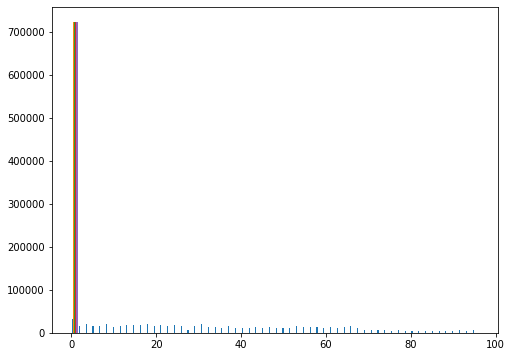

In [85]:
testMAE2 = np.mean(np.abs(testPredict - X_test), axis=1)
plt.hist(testMAE, bins=60)